In [18]:
# ORIGINAL CODE : https://machinelearningmastery.com/weighted-average-ensemble-with-python/
# By Jason Brownlee - MAY 2021

# Modifed by MAHAYASA ADIPUTRA - OCT 2022
import time
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as mt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_predict

le = LabelEncoder()
start_time = time.time()
# get the dataset
# Importing the dataset
dataset=pd.read_csv('../../data/dataset1.csv')
dataset=dataset.dropna()
dataset=dataset.fillna(0)

#transform data into numeric value
dataset['Partner']=le.fit_transform(dataset['Partner'])
dataset['Dependents']=le.fit_transform(dataset['Dependents'])
dataset['PhoneService']=le.fit_transform(dataset['PhoneService'])
dataset['MultipleLines']=le.fit_transform(dataset['MultipleLines'])
dataset['InternetService']=le.fit_transform(dataset['InternetService'])
dataset['OnlineSecurity']=le.fit_transform(dataset['OnlineSecurity'])
dataset['DeviceProtection']=le.fit_transform(dataset['DeviceProtection'])
dataset['TechSupport']=le.fit_transform(dataset['TechSupport'])
dataset['StreamingTV']=le.fit_transform(dataset['StreamingTV'])
dataset['StreamingMovies']=le.fit_transform(dataset['StreamingMovies'])
dataset['Contract']=le.fit_transform(dataset['Contract'])
dataset['PaperlessBilling']=le.fit_transform(dataset['PaperlessBilling'])
dataset['PaymentMethod']=le.fit_transform(dataset['PaymentMethod'])
dataset['gender']=le.fit_transform(dataset['gender'])
dataset['OnlineBackup']=le.fit_transform(dataset['OnlineBackup'])

#filling missing value with mean
dataset['TotalCharges'].replace(to_replace = 0, value = dataset['TotalCharges'].mean(), inplace=True)
X=dataset.drop(['Churn','customerID'],axis=1)
y=dataset["Churn"]
y = le.fit_transform(y)
#imblearn SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


# get a list of base models
def get_models():
	models = list()
	models.append(('xb', XGBClassifier(colsample_bytree=0.6, max_depth = 5, gamma=1.5, min_child_weight=5)))
	models.append(('rf', RandomForestClassifier(n_estimators =100, criterion = 'gini', random_state = 0)))
	models.append(('ab', AdaBoostClassifier(n_estimators=100,learning_rate=0.1,algorithm='SAMME.R')))
	return models
 
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		acc = roc_auc_score(y_val, yhat)
		# store the performance
		scores.append(acc)
		# report model performance
	return scores

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train, X_val, y_train, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_val)
# evaluate predictions
score = roc_auc_score(y_val, yhat)
print('Weighted Avg AUC ROC: %.3f' % (mean(score)*100))
print('STD AUC ROC: %.3f' % (std(score)))
print("--- %s seconds ---" % (time.time() - start_time))

[0.8303782991859954, 0.8510105917792246, 0.8002035011922292]
Weighted Avg AUC ROC: 85.098
STD AUC ROC: 0.000
--- 4.334323167800903 seconds ---


<AxesSubplot:>

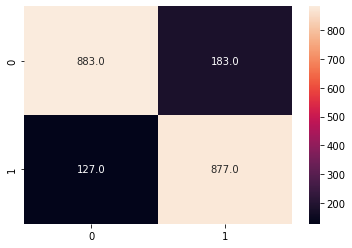

In [56]:
import seaborn as sns
cm = confusion_matrix(y_val, yhat)
sns.heatmap(cm, annot=True,fmt=".1f")

In [19]:
import sklearn.metrics as mt
print ("The precision  is - ")
print (mt.precision_score(y_val, yhat))
print ("The recall o is - ")
print (mt.recall_score(y_val, yhat))
print ("The F1 Score is - ")
print (mt.f1_score(y_val, yhat))

The precision  is - 
0.8261278195488722
The recall o is - 
0.8754980079681275
The F1 Score is - 
0.8500967117988394
